# OP2 Introduction

The Jupyter notebook for this demo can be found in:
   - docs/quick_start/demo/op2_demo.ipynb
   - https://github.com/SteveDoyle2/pyNastran/tree/master/docs/quick_start/demo/op2_demo.ipynb


## Why use the OP2?  Why not use the F06/PCH file?
Most people are comfortable with the F06.  However, it's:
 - Ironically, a lot harder to parse.  The OP2 is very structured.
 - Much, much, much slower.  We can read entire blocks of arrays with a single call.  The data is already typed.
 - Much, much more memory inefficient because we aren't appending strings onto lists and turning that into a numpy array.

F06 parsers get ridiculously hard when you start do complicated results, like:
 - single subcase buckling
 - superelements
 - SOL 200 optimization with sub-optimization
 - SPOINTs

The pyNastran OP2 Reader is fast, highly validated, and it supports most result types.  The data in the OP2 is also more accurate because there is no rounding.

## Validating an OP2

The ```test_op2``` script is created when you run ```python setup.py develop``` or ```python setup.py install``` on pyNastran.  Assuming it's on your path (it'll be in Python27\Scripts or something similar), you can run:

```
>>> test_op2 -f solid_bending.op2
```
The ```-f``` tells us to print out ```solid_bending.test_op2.f06```, which can be compared to your F06 for a small file to build confidence in the reader.  It's also useful when you want an F06 of your model without rerunning Nastran just to see what's in it.

If you have a large model, you can make ```test_op2``` run much, much faster.  The ```-c``` flag disables double-reading of the OP2.  By default, ```test_op2``` uses two different read methods (the old method and new method) to ensure that results are read in properly.  When running the code, this is turned off, but is turned on for ```test_op2```.
```
>>> test_op2 -fc solid_bending.op2
```

## Import the packages

In [1]:
import os
import copy
import numpy as np
np.set_printoptions(precision=2, threshold=20, suppress=True)

import pyNastran
pkg_path = pyNastran.__path__[0]

from pyNastran.utils import print_bad_path
from pyNastran.op2.op2 import read_op2
from pyNastran.utils import object_methods, object_attributes

import pandas as pd

### Sets default precision of real numbers for pandas output


In [2]:
pd.set_option('precision', 3)
np.set_printoptions(precision=3, threshold=20)

As with the BDF, we can use the long form and the short form.  However, the long form for the ``OP2`` doesn't really add anything.  So, let's just use the short form.

In addition to the default numpy support, there is also **```pandas```** dataframe support.

In [3]:
#op2_filename = r'D:\work\pynastran_0.8.0\models\iSat\ISat_Launch_Sm_Rgd.op2'
#op2_filename = r'D:\work\pynastran_0.8.0\models\iSat\ISat_Launch_Sm_4pt.op2'
op2_filename = os.path.abspath(os.path.join(pkg_path, '..', 'models', 'iSat', 'ISat_Launch_Sm_4pt.op2'))
assert os.path.exists(op2_filename), print_bad_path(op2_filename)

# define the input file with a file path
op2 = read_op2(op2_filename, build_dataframe=True, debug=False)

c:\nasa\m4\formats\git\pynastran_1.2\pyNastran\op2\op2.py:752: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  obj.build_dataframe()


## OP2 Introspection
The ```get_op2_stats()``` function lets you quickly understand what in an op2.

In [4]:
print(op2.get_op2_stats())

eigenvectors[1]
  isubcase = 1
  type=RealEigenvectorArray ntimes=167 nnodes=5379, table_name=OUGV1
  data: [t1, t2, t3, r1, r2, r3] shape=[167, 5379, 6] dtype=float32
  node_gridtype.shape = (5379, 2)
  sort1
  modes = [  1   2   3 ... 165 166 167]
  eigns = [   2757.896    3568.136    9686.188 ... 6162773.5   6169898.5
 6229583.   ]
  mode_cycles = [  8.358   9.507  15.664 ... 395.101 395.329 397.237]

cbar_force[1]
  type=RealCBarForceArray ntimes=167 nelements=827; table_name='OEF1X'
  data: [ntimes, nnodes, 8] where 8=[bending_moment_a1, bending_moment_a2, bending_moment_b1, bending_moment_b2, shear1, shear2, axial, torque]
  data.shape = (167, 827, 8)
  element.shape = (827,)
  element name: CBAR-34
  sort1
  modes = [  1   2   3 ... 165 166 167]
  eigns = [   2757.896    3568.136    9686.188 ... 6162773.5   6169898.5
 6229583.   ]
  cycles = [  8.358   9.507  15.664 ... 395.101 395.329 397.237]

ctria3_stress[1]
  type=RealPlateStressArray ntimes=167 nelements=32 nnodes_per_elem

### If that's too long...

In [5]:
print(op2.get_op2_stats(short=True))

eigenvectors[1]
cbar_force[1]
ctria3_stress[1]
cquad4_stress[1]



## Acccessing the Eigenvectors object

Eigenvectors are the simplest object.  They use the same class as for displacements, velocity, acceleration, SPC Forces, MPC Forces, Applied Loads, etc.  These are all node-based tables with TX, TY, TZ, RX, RY, RZ.  Results are in the analysis coordinate frame (CD), which is defined by the GRID card.

### Numpy-based Approach
We'll first show off the standard ```numpy``` based results on a transient case.  Static results are the same, except that you'll always use the 0th index for the "time" index.

The tutorial is intetionally just accessing the objects in a very clear, though inefficient way.  The OP2 objects can take full advantage of the numpy operations.

In [6]:
# what modes did we analyze:  1 to 167
print("loadcases = %s" % op2.eigenvectors.keys())

# get subcase 1
eig1 = op2.eigenvectors[1]

modes = eig1.modes
times = eig1._times #  the generic version of modes
print("modes = %s\n" % modes)
print("times = %s\n" % times)

imode2 = 1 # corresponds to mode 2
mode2 = eig1.data[imode2, :, :]

print('first 10 nodes and grid types\nNid Gridtype\n%s' % eig1.node_gridtype[:10, :])
node_ids = eig1.node_gridtype[:, 0]

index_node10 = np.where(node_ids == 10)[0]  # we add the [0] because it's 1d
mode2_node10 = mode2[index_node10]
print("translation mode2_node10 = %s" % eig1.data[imode2, index_node10, :3].ravel())
print("rotations mode2_node10 = %s" % eig1.data[imode2, index_node10, 3:].ravel())

loadcases = dict_keys([1])
modes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167]

times = [  1.   2.   3. ... 165. 166. 167.]

first 10 nodes and grid types
Nid Gridtype
[[ 1  1]
 [ 2  1]
 [ 3  1]
 [ 4  1]
 [ 5  1]
 [ 6  1]
 [ 7  1]
 [ 8  1]
 [ 9  1]
 [10  1]]
translation mode2_node10 = [0.    0.008 0.002]
rotations 

### Pandas-based Approach

If you like pandas, you can access all the OP2 objects, which is very useful within the Jupyter Notebook.  Different objects will look differently, but you can change the layout.

If you're trying to learn pandas, there are many tutorials online, such as:
http://pandas.pydata.org/pandas-docs/stable/10min.html

or a very long, but good video:

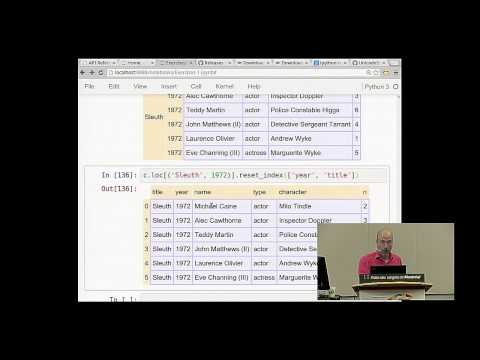

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('5JnMutdy6Fw')
#https://www.youtube.com/watch?v=5JnMutdy6Fw

In [8]:
# get subcase 1
eig1 = op2.eigenvectors[1]

eig1.data_frame

Mode               1          2          3          4          5          6    \
Freq           8.358      9.507      15.664     20.229     20.306     20.548    
Eigenvalue   2.758e+03  3.568e+03  9.686e+03  1.615e+04  1.628e+04  1.667e+04   
Radians       52.516     59.734     98.418     127.102    127.585    129.107    
NodeID Item                                                                     
1      t1   -5.548e-03  4.671e-06 -1.816e-04 -5.670e-02 -1.721e-04 -4.175e-02   
       t2    2.133e-04  5.699e-03  2.393e-02  5.803e-04  1.812e-04  1.971e-04   
       t3   -8.469e-04  1.512e-03  7.038e-03 -8.160e-03  1.385e-03 -6.210e-03   
       r1   -8.399e-06 -2.241e-04 -1.035e-03 -4.509e-05 -6.317e-05 -9.635e-06   
       r2   -2.507e-04  1.228e-06 -8.730e-06 -2.571e-03 -6.174e-06 -1.767e-03   
       r3   -5.261e-05 -1.187e-06 -1.986e-04 -1.310e-04  2.861e-05 -4.677e-05   
2      t1   -5.548e-03  4.671e-06 -1.816e-04 -5.670e-02 -1.721e-04 -4.175e-02   
       t2    1.081e-04  5.696e-03  2.353e-02  3.182e-04  2.384e-04  1.036e-04   
       t3   -3.455e-04  1.510e-03  7.056e-03 -3.018e-03  1.398e-03 -2.676e-03   
       r1   -8.399e-06 -2.241e-04 -1.035e-03 -4.509e-05 -6.317e-05 -9.635e-06   
       r2   -2.507e-04  1.228e-06 -8.730e-06 -2.571e-03 -6.174e-06 -1.767e-03   
       r3   -5.261e-05 -1.187e-06 -1.986e-04 -1.310e-04  2.861e-05 -4.677e-05   
3      t1   -6.169e-03  7.911e-06 -2.157e-04 -6.310e-02 -1.896e-04 -4.617e-02   
       t2    2.295e-04  6.255e-03  2.639e-02  6.021e-04  2.805e-04  1.856e-04   
       t3   -8.457e-04  1.512e-03  7.034e-03 -8.137e-03  1.386e-03 -6.198e-03   
       r1   -8.883e-06 -2.240e-04 -1.036e-03 -5.241e-05 -6.649e-05 -6.665e-06   
       r2   -2.507e-04  1.229e-06 -8.736e-06 -2.571e-03 -6.175e-06 -1.767e-03   
       r3   -4.657e-05  2.289e-06 -8.570e-06 -2.151e-05 -8.187e-06  1.310e-05   
4      t1   -6.169e-03  7.956e-06 -2.155e-04 -6.310e-02 -1.906e-04 -4.617e-02   
       t2    1.295e-04  6.253e-03  2.619e-02  4.726e-04  3.533e-04  1.577e-04   
       t3   -3.469e-04  1.510e-03  7.059e-03 -3.040e-03  1.396e-03 -2.688e-03   
       r1   -7.731e-06 -2.241e-04 -1.037e-03 -3.841e-05 -6.177e-05 -1.181e-05   
       r2   -2.507e-04  1.229e-06 -8.734e-06 -2.571e-03 -6.171e-06 -1.767e-03   
       r3   -4.712e-05  2.923e-07  5.696e-05 -2.570e-05 -3.632e-06  1.221e-05   
5      t1   -6.801e-03  1.081e-05 -2.253e-04 -6.955e-02 -2.029e-04 -5.058e-02   
       t2    2.553e-04  6.819e-03  2.910e-02  8.057e-04  4.970e-04  2.453e-04   
       t3   -8.469e-04  1.512e-03  7.038e-03 -8.160e-03  1.385e-03 -6.210e-03   
       r1   -8.399e-06 -2.241e-04 -1.035e-03 -4.509e-05 -6.317e-05 -9.635e-06   
       r2   -2.507e-04  1.228e-06 -8.730e-06 -2.571e-03 -6.174e-06 -1.767e-03   
       r3   -5.261e-05 -1.187e-06 -1.986e-04 -1.310e-04  2.861e-05 -4.677e-05   
...                ...        ...        ...        ...        ...        ...   
5629   t1    7.413e-05 -8.245e-05 -3.908e-04  3.482e-03 -3.748e-05  2.988e-04   
       t2    4.452e-05 -2.089e-04 -5.166e-03  2.748e-04  1.754e-04  4.173e-04   
       t3    1.283e-04  1.048e-03  8.983e-03  5.709e-04  1.808e-04  1.258e-03   
       r1    3.005e-07  5.476e-05  6.343e-04  6.334e-06 -2.493e-06  2.715e-06   
       r2   -1.195e-05 -1.468e-05 -9.874e-05  2.889e-07 -7.292e-06 -1.234e-04   
       r3    2.865e-06  1.522e-05  6.913e-05 -4.280e-06  4.744e-06  2.949e-05   
5630   t1    0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
       t2    0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
       t3    0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
       r1    1.815e-05 -9.454e-05 -3.224e-04 -3.568e-05 -1.340e-05 -3.384e-05   
       r2    1.174e-04  8.335e-07 -1.801e-05  1.328e-03 -2.449e-05  7.252e-04   
       r3   -1.512e-05  3.817e-05  2.898e-04 -7.733e-06  1.063e-06 -1.915e-06   
5631   t1    0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
       t2    0.000e+00  0.000e+

## Accessing the plate stress/strain
Results are stored on a per element type basis.

The OP2 is the same as an F06, so CQUAD4 elements have centroidal-based results or centroidal-based as well as the results at the 4 corner nodes.

Be careful about what you're accessing.

In [9]:
# element forces/stresses/strains are by element type consistent with the F06, so...
plate_stress = op2.cquad4_stress[1]
print("plate_stress_obj = %s" % type(plate_stress))

# the set of variables in the RealPlateStressArray
print("plate_stress = %s\n" % plate_stress.__dict__.keys())

# list of parameters that define the object (e.g. what is the nonlinear variable name
print("data_code_keys = %s\n" % plate_stress.data_code.keys())

# nonlinear variable name
name = plate_stress.data_code['name']
print("name = %r" % plate_stress.data_code['name'])

print("list-type variables = %s" % plate_stress.data_code['data_names'])

# the special loop parameter
# for modal analysis, it's "modes"
# for transient, it's "times"
# or be lazy and use "_times"
print("modes = %s" % plate_stress.modes) # name + 's'


# extra list-type parameter for modal analysis; see data_names
#print("mode_cycles =", plate_stress.mode_cycles)

plate_stress_obj = <class 'pyNastran.op2.tables.oes_stressStrain.real.oes_plates.RealPlateStressArray'>
plate_stress = dict_keys(['element_type', 'element_name', 'nonlinear_factor', '_times', 'result_name', 'approach_code', 'analysis_code', 'data', 'isubcase', 'ogs', 'pval_step', 'name', 'superelement_adaptivity_index', '_count', 'is_built', 'format_code', 'sort_code', 'table_code', 'title', 'subtitle', 'label', 'num_wide', 'device_code', 'table_name', 'data_frame', 'dt', 'ntimes', 'ntotal', '_ntotals', 'load_as_h5', 'h5_file', 'data_code', 'ielement', 'nelements', 'nnodes', '_encoding', '_times_dtype', 'cycle', 'data_names', 'eign', 'is_msc', 'is_strain_flag', 'is_stress_flag', 'load_set', 'mode', 'mode2', 's_code', 'sort_bits', 'sort_method', 'stress_bits', 'subtitle_original', 'tCode', 'thermal', 'thermal_bits', 'modes', 'eigns', 'mode2s', 'cycles', 'itotal', 'itime', 'element_node', 'words'])

data_code_keys = dict_keys(['_encoding', 'load_as_h5', 'is_msc', 'table_name', 'approach_

### Similar to the BDF, we can use object_attributes/methods

In [10]:
#print "attributes =", object_attributes(plate_stress)
print("methods = %s\n" % object_methods(plate_stress))
print('methods2= %s\n' % plate_stress.object_methods())
print("headers = %s\n" % plate_stress.get_headers())

methods = ['add_new_eid_sort1', 'add_new_node_sort1', 'add_sort1', 'apply_data_code', 'approach_code_str', 'build', 'build_dataframe', 'cast_grid_type', 'code_information', 'eid_to_element_node_index', 'export_to_hdf5', 'finalize', 'get_data_code', 'get_element_index', 'get_element_type', 'get_headers', 'get_nnodes_bilinear', 'get_stats', 'get_unsteady_value', 'is_bilinear', 'is_magnitude_phase', 'is_sort1_new', 'is_thermal', 'object_attributes', 'object_methods', 'print_data_members', 'print_table_code', 'recast_gridtype_as_string', 'set_as_sort1', 'set_table_type', 'update_data_code', 'update_dt', 'update_t_code', 'write_f06', 'write_op2']

methods2= ['add_new_eid_sort1', 'add_new_node_sort1', 'add_sort1', 'apply_data_code', 'approach_code_str', 'build', 'build_dataframe', 'cast_grid_type', 'code_information', 'eid_to_element_node_index', 'export_to_hdf5', 'finalize', 'get_data_code', 'get_element_index', 'get_element_type', 'get_headers', 'get_nnodes_bilinear', 'get_stats', 'get_uns

### Number of Nodes on a CQUAD4
 - For CENT, there is 1 centroidal stress at two locations 
 - For BILIN, there are 5 stresses at two locations (4 nodes + centroidal)
 - node_id=0 indicates a centroidal quantity
 - CTRIA3s are always centroidal

#### What sets this?
    STRESS(real, sort1, BILIN) = ALL   # centroid + 4 corner nodes
    STRESS(real, sort1, CENT) = ALL    # centroid

    STRAIN(real, sort1, BILIN) = ALL   # centroid + 4 corner nodes
    STRAIN(real, sort1, CENT) = ALL    # centroid

#### How do we know if we're bilinear?
```
print("is_bilinear = %s\n" % plate_stress.is_bilinear())
```

#### What locations are chosen?
 That depends on fiber distance/fiber curvature...
 - fiber_curvature - mean stress ($\sigma_{alt}$) & slope ($\sigma_{mean}$)
 
    $$ \sigma_{top} = \sigma_{alt} + \frac{t}{2} \sigma_{mean}$$
    
    $$ \sigma_{btm} = \sigma_{alt} + \frac{t}{2} \sigma_{mean}$$
 
 - fiber_distance - upper and lower surface stress (o_top; o_btm)
 - If you have stress, fiber_distance is always returned regardless of your option.

#### What sets this?
    STRAIN(real, sort1, FIBER) = ALL   # fiber distance/default
    STRAIN(real, sort1, STRCUR) = ALL  # strain curvature


#### How do we know if we're using fiber_distance?
```
print("is_fiber_distance = %s" % plate_stress.is_fiber_distance())
```

## Accessing results

#### Note that this is intentionally done iinefficiently to access specific entries in order to explain the data structure.

In [11]:
# element forces/stresses/strains are by element type consistent 
# with the F06, so...

def abs_max_min(vals):
    absvals = list(abs(vals))
    maxval = max(absvals)
    i = absvals.index(maxval)
    return vals[i]

#-----------------------------
# again, we have linear quads, so two locations per element
print("element_node[:10, :] =\n%s..." % plate_stress.element_node[:10, :])

# lets get the stress for the first 3 CQUAD4 elements
eids = plate_stress.element_node[:, 0]
ueids = np.unique(eids)
print('ueids = %s' % ueids[:3])

# get the first index of the first 5 elements
ieids = np.searchsorted(eids, ueids[:3])
print('ieids = %s' % ieids)

# the easy way to slice data for linear plates
ieids5 = np.vstack([ieids, ieids + 1]).ravel()
ieids5.sort()

print('verify5:\n%s' % ieids5)

#-----------------------------
itime = 0 # static analysis / mode 1
if plate_stress.is_von_mises:  # True
    ovm = plate_stress.data[itime, :, 7]
    print('we have von mises data; ovm=%s\n' % ovm)
else:
    omax_shear = plate_stress.data[itime, :, 7]
    print('we have max shear data; omax_shear=%s\n' % omax_shear)


print("[layer1, layer2, ...] = %s" % ovm[ieids5])

ieid1000 = np.where(eids == 1000)[0]
print('ieid1000 = %s' % ieid1000)
ovm_mode6_eid1000 = ovm[ieid1000]
print("ovm_mode6_eid1000 = %s -> %s" % (ovm_mode6_eid1000, abs_max_min(ovm_mode6_eid1000)))

element_node[:10, :] =
[[1 0]
 [1 0]
 [2 0]
 [2 0]
 [3 0]
 [3 0]
 [4 0]
 [4 0]
 [5 0]
 [5 0]]...
ueids = [1 2 3]
ieids = [0 2 4]
verify5:
[0 1 2 3 4 5]
we have von mises data; ovm=[54.222  5.041 13.143 ...  2.34   6.146  7.368]

[layer1, layer2, ...] = [54.222  5.041 13.143 21.222 78.545 17.91 ]
ieid1000 = [1998 1999]
ovm_mode6_eid1000 = [90.618 94.091] -> 94.09056


In [12]:
# see the difference between "transient"/"modal"/"frequency"-style results
# and "nodal"/"elemental"-style results
# just change imode

imode = 5  # mode 6; could just as easily be dt
iele = 10  # element 10
ilayer = 1

ieid10 = np.where(eids == iele)[0][ilayer]
print('ieid10 = %s' % ieid10)
print(plate_stress.element_node[ieid10, :])


# headers = [u'fiber_distance', u'oxx', u'oyy', u'txy', u'angle', u'omax', u'omin', u'von_mises']
print("ps.modes = %s" % plate_stress.modes[imode])
print("ps.cycles = %s" % plate_stress.cycles[imode])
print("oxx = %s" % plate_stress.data[imode, ieid10, 1])
print("oyy = %s" % plate_stress.data[imode, ieid10, 2])
print("txy = %s" % plate_stress.data[imode, ieid10, 3])
print("omax = %s" % plate_stress.data[imode, ieid10, 5])
print("omin = %s" % plate_stress.data[imode, ieid10, 6])
print("ovm/max_shear = %s" % plate_stress.data[imode, ieid10, 7])

if plate_stress.is_fiber_distance:
    print("fiber_distance = %s" % plate_stress.data[imode, ieid10, 0])
else:
    print("curvature = %s" % plate_stress.data[imode, ieid10, 0])

ieid10 = 19
[10  0]
ps.modes = 6
ps.cycles = 20.548073657198046
oxx = -18.872536
oyy = -20.16303
txy = -8.309847
omax = -11.182922
omin = -27.852644
ovm/max_shear = 24.276606
fiber_distance = -0.4


In [13]:
from pyNastran.bdf.bdf import read_bdf
bdf_filename = os.path.abspath(os.path.join(pkg_path, '..', 'models', 'iSat', 'ISat_Launch_Sm_4pt.dat'))
model = read_bdf(bdf_filename, debug=False)
mass, cg, I = model.mass_properties()

### Let's print out the actual mass properties from the OP2 and get the same result as the F06

We need ``PARAM,POSTEXT,YES`` in out BDF to get the Grid Point Weight Table

In [14]:
gpw = op2.grid_point_weight
#print(gpw.object_attributes())

print(gpw)
gpw.object_methods()
#gpw.write_f06?
print(gpw.get_stats())

#### We can also write the full ``F06``

In [15]:
import getpass
name = getpass.getuser()
os.chdir(os.path.join(r'C:\Users', name, 'Desktop'))

# write the F06 with Real/Imaginary or Magnitude/Phase
# only matters for complex results
op2.write_f06('isat.f06', is_mag_phase=False)

!head -n 40 isat.f06

1    ISAT_SM_LAUNCH_4PT MODES TO 400 HZ                                    FEBRUARY  14, 2018  pyNastran v1.2.0       PAGE     1
     
0                                                                                                            SUBCASE 1
                                         R E A L   E I G E N V E C T O R   N O .          1
 
      POINT ID.   TYPE          T1             T2             T3             R1             R2             R3
             1      G     -5.547863E-03   2.133077E-04  -8.469186E-04  -8.399206E-06  -2.506956E-04  -5.261146E-05
             2      G     -5.547863E-03   1.080848E-04  -3.455275E-04  -8.399206E-06  -2.506956E-04  -5.261146E-05
             3      G     -6.169366E-03   2.295251E-04  -8.457433E-04  -8.882780E-06  -2.506924E-04  -4.657186E-05
             4      G     -6.169462E-03   1.295465E-04  -3.468718E-04  -7.731095E-06  -2.506902E-04  -4.712092E-05
             5      G     -6.801341E-03   2.553037E-04  -8.469186E-04  -8.399206E-

In [16]:
#from IPython.display import display, Math, Latex

The mass results are different as pyNastran's mass assumes point masses
   $$m_{plates} = A (\rho t + nsm)$$
   $$m_{solid} = V \rho$$
   $$m_{bars} = L (\rho A + nsm)$$
   $$I = m r^2$$

The larger your model is and the further from the origin, the more accurate the result.
For some applications (e.g. a weight breakdown), this is probably be fine.

In [17]:
print('cg =\n%s' % gpw.cg)
print('cg = %s' % cg)

cg =
None
cg = [ -0.034  -2.531 -18.468]


## It's not like Nastran is perfect either.

### Limitations

1.  You cannot do weight statements in Nastran by component/property/material.

2.  Everything is always summmed up (e.g. you can have different geometry in Subcase 2 and MPCs connecting physical geomtry, with other parts flying off into space).

These are things that pyNastran ``can`` do.

In [18]:
from pyNastran.bdf.bdf import read_bdf
bdf_filename = os.path.abspath(os.path.join(pkg_path, '..', 'models', 'iSat', 'ISat_Launch_Sm_4pt.dat'))
model = read_bdf(bdf_filename, debug=False)

### Weight Statement

Let's get the breakdown by property ID

In [19]:
#help(model.mass_properties)

pid_to_eids_map = model.get_element_ids_dict_with_pids()
#print(pid_to_eids_map.keys())
print('pid, mass, cg, [ixx, iyy, izz, ixy, ixz, iyz]')
for pid, eids in sorted(pid_to_eids_map.items()):
    mass, cg, inertia = model.mass_properties(element_ids=eids, mass_ids=[], reference_point=[0., 0., 0.])
    print('%-6s %-.6f %-38s %s' % (pid, mass, cg, inertia))

mass_ids = list(model.masses.keys())
mass, cg, inertia = model.mass_properties(element_ids=[], mass_ids=mass_ids, reference_point=[0., 0., 0.])
print('%-6s %-.6f %-38s %s' % ('mass', mass, cg, inertia))

pid, mass, cg, [ixx, iyy, izz, ixy, ixz, iyz]
1      0.027278 [  0.   0. -20.]                       [3.699 6.553 4.384 0.    0.    0.   ]
2      0.047993 [ -0.   0. -20.]                       [18.033 18.033 12.454 -0.    -0.     0.   ]
3      0.020998 [  0.  -0. -20.]                       [5.881 3.907 5.27  0.    0.    0.   ]
4      0.012216 [  0.043   0.438 -19.702]              [2.346 3.23  2.019 0.01  0.005 0.052]
5      0.330158 [  0.    2.2 -20. ]                    [63.317 28.366 41.752  0.     0.     0.   ]
7      0.027813 [  0.  -0. -20.]                       [ 8.141  8.141  9.438 -0.    -0.    -0.   ]
8      0.081584 [  0.   0. -20.]                       [15.087 15.087 30.174 -0.     0.     0.   ]
9      0.077642 [  0.   0. -20.]                       [17.017 17.017 18.911 -0.    -0.     0.   ]
10     0.000236 [  0.  -0. -20.]                       [ 0.035  0.035  0.057 -0.    -0.    -0.   ]
11     0.041700 [ -1.025  23.773 -12.016]              [ 0.666  0.988  0.348 -0.0